### Data exploration  on potential long-lived covid patients

In [76]:
import os
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np


def read_csv(file_path, sep=','):
    """
    Reads the CSV file into a DataFrame.

    Args:
        file_path (str): Path to the CSV file.

    Returns:
        pd.DataFrame: The DataFrame containing the data from the CSV file.
    """
    return pd.read_csv(file_path, sep=sep)


def plot_histogram_by_quartile(data, exam_type='CTs and X-rays', N='116'):
    # Fixed quartile ranges
    quartile_ranges = {
        # 'Q1': [-400, -16],
        'Q2': [-15, 60],
        # 'Q3': [91, 149],
        'Q4': [150, 401]
    }

    # Create a dictionary to store the number of medical exams per quartile
    histogram = {quartile: [] for quartile in quartile_ranges.keys()}

    # Categorize the delta days into the respective quartile
    for delta_days in data:
        for quartile, (lower_bound, upper_bound) in quartile_ranges.items():
            if lower_bound <= delta_days <= upper_bound:
                histogram[quartile].append(delta_days)
                break

    # Calculate the number of samples in each quartile
    sample_counts = {quartile: len(delta_days) for quartile, delta_days in histogram.items()}

    ## Get the total number of samples
    total_number_of_samples = sum(sample_counts.values())

    # Create a color map for each quartile
    color_map = {
        # 'Q1': 'orange',
        'Q2': 'red',
        # 'Q3': 'green',
        'Q4': 'blue'
    }

    # Create a histogram plot for each quartile
    plt.figure(figsize=(10, 6))
    for quartile, delta_days in histogram.items():
        plt.hist(delta_days, bins=np.linspace(-400, 401, 80), alpha=0.5, label=f"{quartile} (s={sample_counts[quartile]})", color=color_map[quartile])

    # Set plot labels and title
    plt.xlabel('Delta Days of ' + exam_type)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of potential long COVID patients (N={N} | S={total_number_of_samples})')

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()


### Filtering only one image per patient in each quartile range

In [77]:
import os
import pandas as pd

dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_125PLCP/'
filename = os.path.join(dir_path, 'potential_long_covid_patients_ris_information.csv')
df = pd.read_csv(filename)

# Define the hospitalization quartile ranges
quartile_ranges = {
        # 'Q1': [-400, -16],
        'Q2': [-15, 60],
        # 'Q3': [91, 149],
        'Q4': [150, 401]
    }

# Function to filter one entry per patient in each quartile range
def filter_one_per_quartile(patient_data):
    filtered_data = []
    patient_data = patient_data.sort_values(by='days')
    for q, (lower, upper) in quartile_ranges.items():
        q_data = patient_data[(patient_data['days'] >= lower) & (patient_data['days'] <= upper)]
        if not q_data.empty:
            # Select the first entry in this quartile range
            filtered_data.append(q_data.iloc[0])
    return pd.DataFrame(filtered_data)

# Group the data by 'patient_id' and apply the filtering function
filtered_data = df.groupby('pseudoid_pid', group_keys=False).apply(filter_one_per_quartile)

# # Count the number of unique patients in 'pseudoid_pid'
# num_unique_patients = df['pseudoid_pid'].nunique()

# Filter data in Q2 and Q4
q2_data = filtered_data[filtered_data['days'].between(-15, 60)]
q4_data = filtered_data[filtered_data['days'].between(150, 500)]
# print("+ Q2 data:", q2_data.shape)
# print("+ Q4 data:", q4_data.shape)

# # Find the subjects that have at least one sample in both q2_data and q4_data
q2_filtered = q2_data[q2_data['pseudoid_pid'].isin(q4_data['pseudoid_pid'])]
# print("+ Q2 filtered:", q2_filtered.shape)

# Find the subjects that have at least one sample in both q4_data and q2_data
q4_filtered = q4_data[q4_data['pseudoid_pid'].isin(q2_data['pseudoid_pid'])]
# print("+ Q4 filtered:", q4_filtered.shape)

## Concatenate the verified data of q2 and q4
plcp_with_2_images = pd.concat([q2_filtered, q4_filtered])
# print("+ PLCP with two images:", plcp_with_2_images.shape)

## Save the verified data
plcp_with_2_images.to_csv(os.path.join(dir_path, 'plcp_with_2_images.csv'), index=False)



#############################################################################################
## Get the unique patients in th plcp_with_2_images
unique_patients = plcp_with_2_images['pseudoid_pid'].unique()
print("+ Unique patients:", len(unique_patients))

## Save the unique patients
pd.DataFrame(unique_patients).to_csv(os.path.join(dir_path, 'verified_plcp_unique_pseudoid_pid.csv'), index=False, header=False)

## Get a subset of the original data with the unique patients and drop the patients thar are not in the unique_patients
verified_plcp_ris_information = df[df['pseudoid_pid'].isin(unique_patients)]
print("+ RIS Information:", verified_plcp_ris_information.shape)

## Save the verified data
verified_plcp_ris_information.to_csv(os.path.join(dir_path, 'verified_plcp_ris_information.csv'), index=False)

+ Unique patients: 116
+ RIS Information: (884, 6)


## Plotting the histogram for the Potential Long COVID Patients

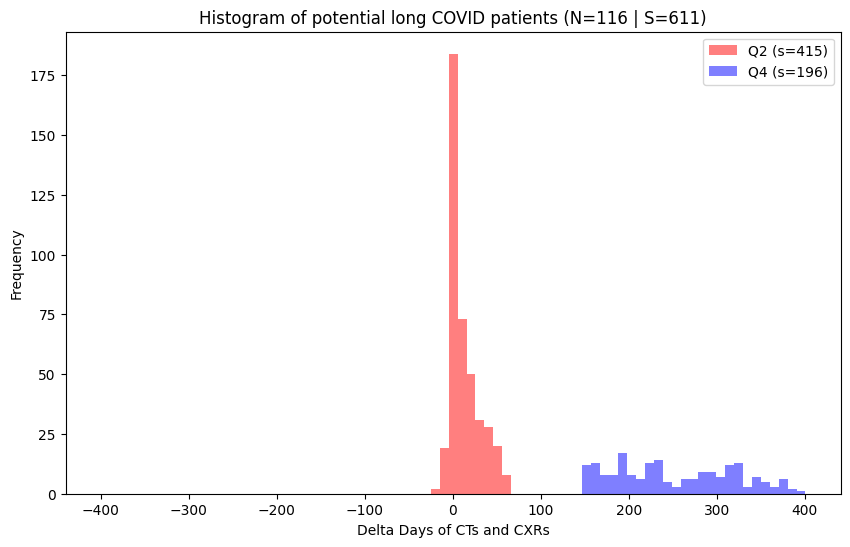

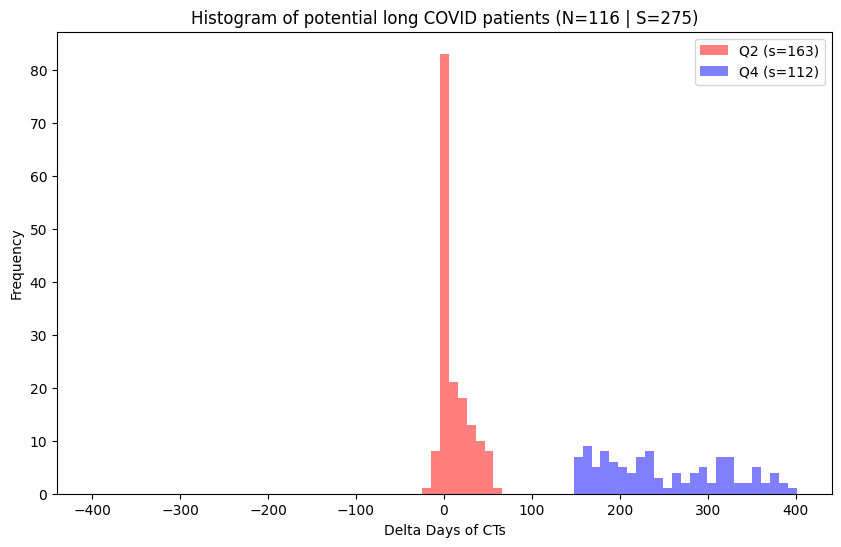

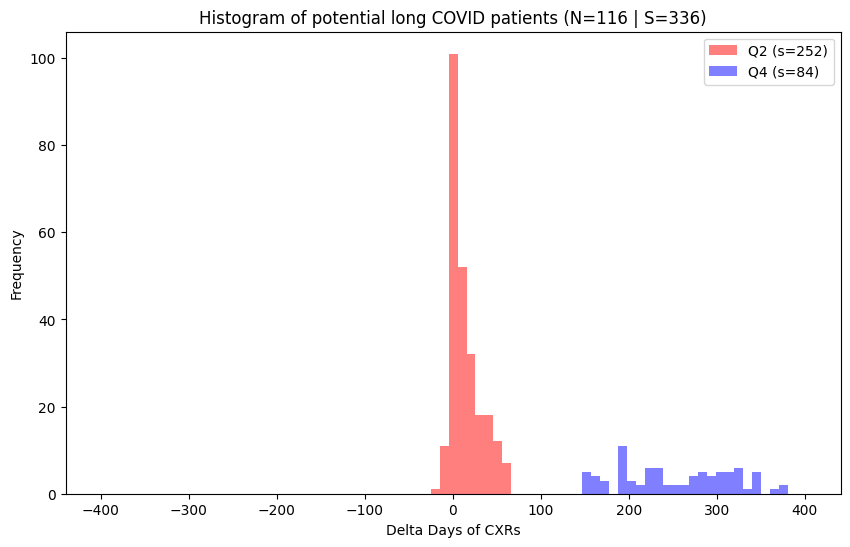

In [78]:
## Plotting the histogram for G1 and G2

dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_125PLCP/'
# filename = os.path.join(dir_path, 'potential_long_covid_patients_filtered_data.csv')
# filename = os.path.join(dir_path, 'plcp_with_2_images.csv')

filename = os.path.join(dir_path, 'verified_plcp_ris_information.csv')

## Read the CSV file into a DataFrame
df = read_csv(filename)
# print(df.head())

## Get the unique number of patients in the DataFrame
N=df['pseudoid_pid'].nunique()


#############################################
## Step 1: Plot histogram for CTs and CXRs ##
#############################################

## Extract the delta days from the DataFrame
delta_days = df['days'].values

## plot the histogram
plot_histogram_by_quartile(delta_days, exam_type='CTs and CXRs', N=N)



#############################################
## Step 2: Plot histogram for CTs          ##
#############################################

## Filter the patients with 'ris_examination_type' == 'CTA, CTTH'
df_CTs = df[df['ris_examination_type'].isin(['CTA', 'CTHATHAB', 'CTHATHOB', 'CTHTH', 'CTHTHABD', 'CTTH', 'CTTHABD', 'CTTHOB', 'CTUB', 'IMPCTTH', 'IMPCTTHAB'])]

## Extract the delta days from the DataFrame 'df_CTs'
delta_days_CTs = df_CTs['days'].values

## plot the histogram
plot_histogram_by_quartile(delta_days_CTs, exam_type='CTs', N=N)



#############################################
## Step 3: Plot histogram for CXRs         ##
#############################################

## Filter the patients with 'ris_examination_type' == 'TH'
df_CXRs = df[df['ris_examination_type'].isin(['TH'])]

## Extract the delta days from the DataFrame 'df_CTs'
delta_days_CXRs = df_CXRs['days'].values

## plot the histogram
plot_histogram_by_quartile(delta_days_CXRs, exam_type='CXRs', N=N)